<a href="https://colab.research.google.com/github/RuslanMavlitov/sf_data_science/blob/main/Time_series_Practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Давайте познакомимся с одним из способов выделения трендовой и сезонной компонент ряда и визуального анализа шума.

In [3]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib import pyplot
import matplotlib.pyplot as plt

## 1. Анализ данных

### 1.1 Чтение данных

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/SF/data/time series/train.zip')

<ipython-input-4-46cbe2bd6ea9>:1: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/drive/MyDrive/SF/data/time series/train.zip')


Пандас упал от нехватки памяти. Малой кровью вопрос можно решить если вспомнить, что пандас умеет читать csv файлы кусочками умеренного размера. Размер фрагмента в строках определяется параметром chunksize.
Указав вполне разумный миллион строк можно выполнить запрос

In [4]:
chunksize = 10 ** 6  # number of rows per chunk
df = pd.DataFrame(columns=['date', 'unit_sales'])
for chunk in pd.read_csv('/content/drive/MyDrive/SF/data/time series/train.zip', chunksize=chunksize, low_memory=False):
    chunk = chunk[chunk.store_nbr==25].groupby("date")['unit_sales'].sum().reset_index()
    df = pd.concat([df,chunk])
df = df.groupby("date").sum().reset_index() # если дата попала в разные чанки
df.to_csv("/content/drive/MyDrive/SF/data/time series/store_25.csv", index=False)

In [5]:
# Переводим индекс в формат datetime
df = df.set_index(pd.DatetimeIndex(df['date'])) 
df = df.drop(['date'], axis = 1)
df.head(2)

unit_sales
date                  
2013-01-01    2511.619
2013-01-02    5316.224

### 1.2 Разложение временного ряда

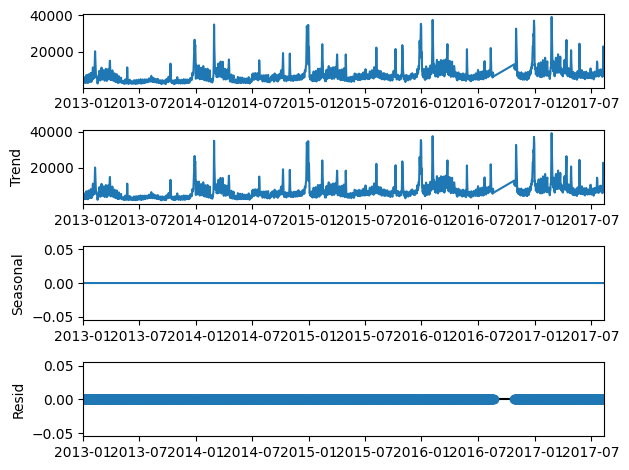

In [6]:
# применяем seasonal_decompose
# эта функция разложит ряд на трендовую, сезонную и шумовую составляющие
decomposition = seasonal_decompose(df, model='additive', period=1)
decomposition.plot()
pyplot.show() # любуемся результатом

In [7]:
trend_part = decomposition.trend # отдельно трендовая составляющаяя
seasonal_part = decomposition.seasonal # отдельно сезонная составляющаяя
residual_part = decomposition.resid # отдельно шум: то, что осталось

In [8]:
# если мы хотим далее анализировать остатки, необходимо избавиться от этих некорректных значений
residual_part = residual_part.dropna()

### 1.3 Тест Дики-Фуллера (на стационарность)

In [9]:
from statsmodels.tsa.stattools import adfuller

test = adfuller(df['unit_sales'])
print ('adf: ', test[0] )
print ('p-value: ', test[1])
print ('Critical values: ', test[4])
if test[0]> test[4]['5%']: # проверка, больше ли критического полученное значение для нашего ряда 
    print ('ряд не стационарен')
else:
    print ('ряд стационарен')

adf:  -4.858992665318184
p-value:  4.188394192907693e-05
Critical values:  {'1%': -3.4344642432857992, '5%': -2.8633571955690647, '10%': -2.5677374399794197}
ряд стационарен


In [10]:
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=3, test_size=7) 
train_test_groups = tscv.split(df.unit_sales) 
for train_index, test_index in train_test_groups:
    print("TRAIN size:", len(train_index), "TEST size:", len(test_index))

TRAIN size: 1597 TEST size: 7
TRAIN size: 1604 TEST size: 7
TRAIN size: 1611 TEST size: 7


## 2.Окна

In [11]:
df_1 = df.iloc[800:900]
df_1 = df_1.reset_index(drop=True)

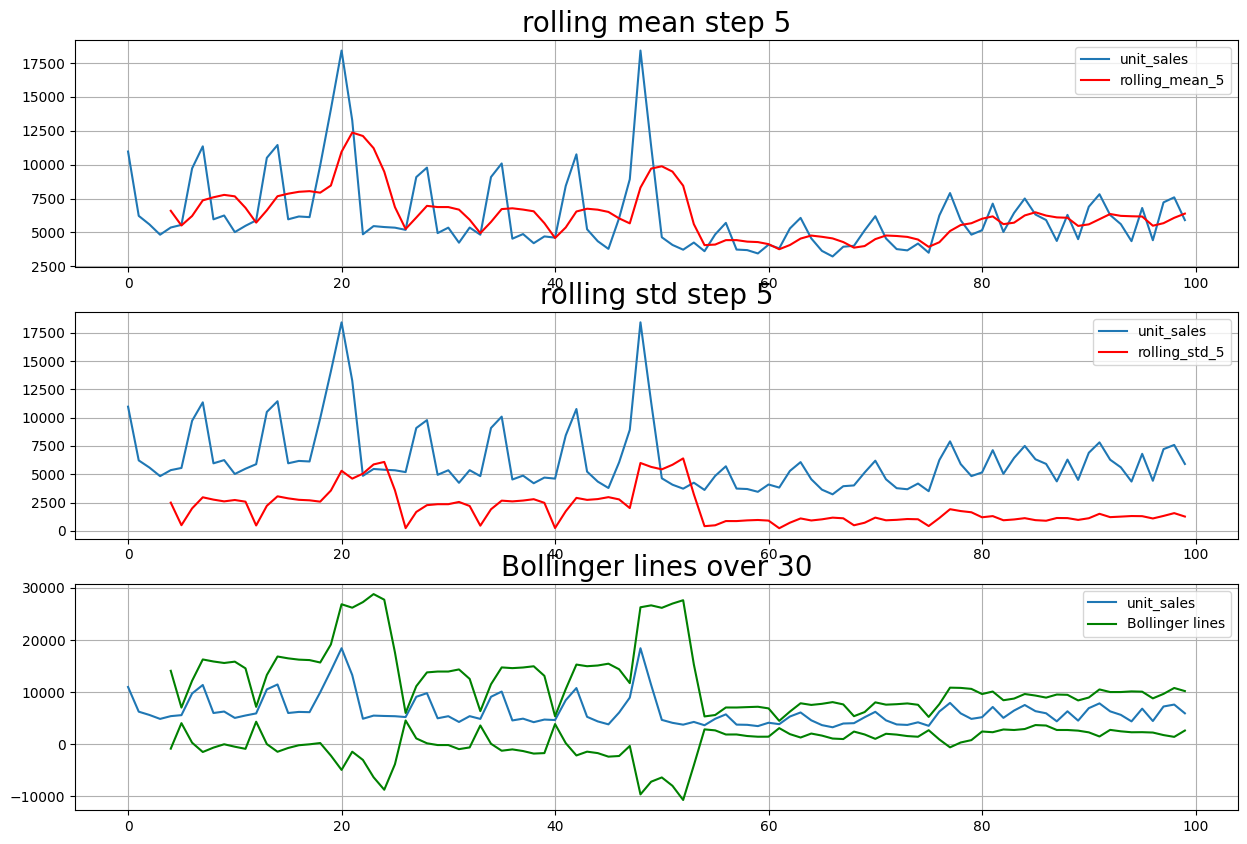

In [12]:
## делаем оконное среднее с окном в 5 точек
df_1['rolling_mean'] = df_1.unit_sales.rolling(window=5).mean()

## делаем оконное квадратическое отклонение c окном 5
df_1['rolling_std']  = df_1.unit_sales.rolling(window=5).std()

# Границы канала Боллинджера
df_1['upper'] = df_1.apply(lambda row: row.rolling_mean + 3 * row.rolling_std, axis=1) 
df_1['lower'] = df_1.apply(lambda row: row.rolling_mean - 3 * row.rolling_std, axis=1) 

## визуализируем
f, ax = plt.subplots(3, 1, figsize=(15, 10))
ax[0].plot(df_1.index, df_1.unit_sales) ## исходные данные
ax[0].plot(df_1.index, df_1.rolling_mean, c='r') ## оконное среднее
ax[0].legend(['unit_sales', 'rolling_mean_5'])
ax[0].set_title('rolling mean step 5', size=20)
ax[0].grid()

ax[1].plot(df_1.index, df_1.unit_sales) ## исходные данные
ax[1].plot(df_1.index, df_1.rolling_std, c='r') ## оконное стандартное отклонение
ax[1].legend(['unit_sales', 'rolling_std_5'])
ax[1].set_title('rolling std step 5', size=20)
ax[1].grid()

ax[2].plot(df_1.index, df_1.unit_sales)  ## исходные данные
ax[2].plot(df_1.index, df_1.upper, c='g') ## верхняя линия Боллинджера
ax[2].plot(df_1.index, df_1.lower,  c='g')  ## нижняя линия Боллинджера
ax[2].legend(['unit_sales', 'Bollinger lines'])
ax[2].set_title('Bollinger lines over 30', size=20)
ax[2].grid()


plt.show()

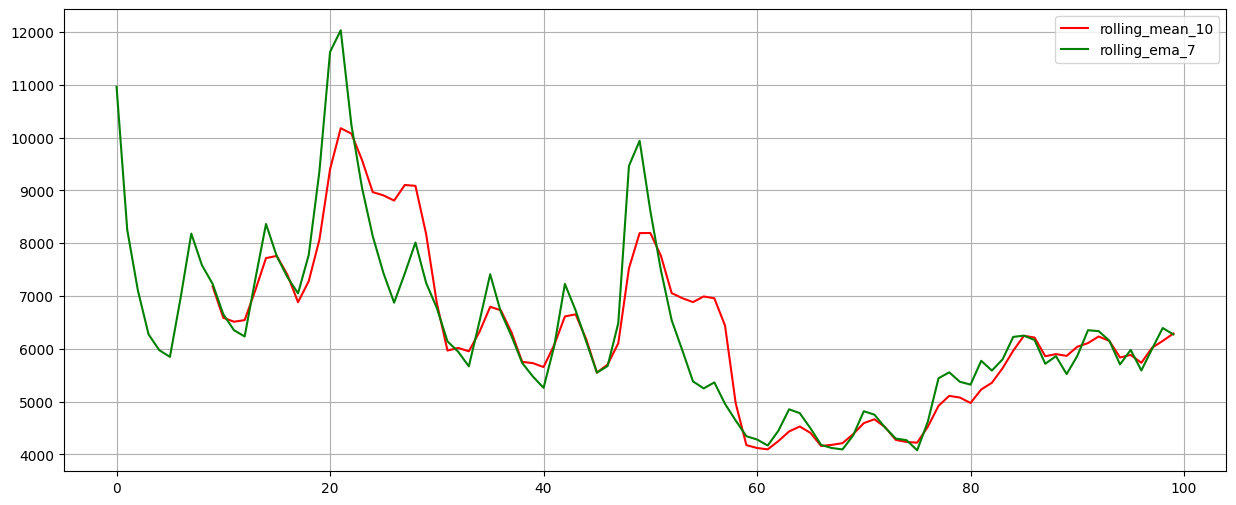

In [13]:
## делаем оконное среднее с окном в 10 точек
df_1['rolling_mean_10'] = df_1.unit_sales.rolling(window=10).mean()

## делаем экспоненциальное среднее с окном в 7 точек
df_1['rolling_ema_7']  = df_1.unit_sales.ewm(span=7).mean() 

## визуализируем
plt.figure(figsize=(15,6))
plt.plot(df_1.index, df_1.rolling_mean_10, c='r') ## среднее с окном в 10 точек
plt.plot(df_1.index, df_1.rolling_ema_7, c='g') ## экспоненциальное среднее с окном в 7 точек
plt.legend(['rolling_mean_10', 'rolling_ema_7'])
plt.grid()

plt.show()

In [14]:
## делаем оконное среднее с окном в 50 точек
df_1['rolling_mean_50'] = df_1.unit_sales.rolling(window=50).mean()

## делаем экспоненциальное среднее с окном в 10 точек
df_1['rolling_ema_10']  = df_1.unit_sales.ewm(span=10).mean() 

#Найдем точку пересечения скользящего среднего с окном 50 и экспоненциального скользящего среднего с окном 10
diff = np.sign(df_1.rolling_mean_50-df_1.rolling_ema_10).diff().dropna()
diff[diff != 0].index

Int64Index([52, 83], dtype='int64')

In [15]:
# Нашли 2 точки, теперь найдем их значения
print(df_1['rolling_mean_50'].iloc[52], df_1['rolling_mean_50'].iloc[83])

7261.2297 5589.73152


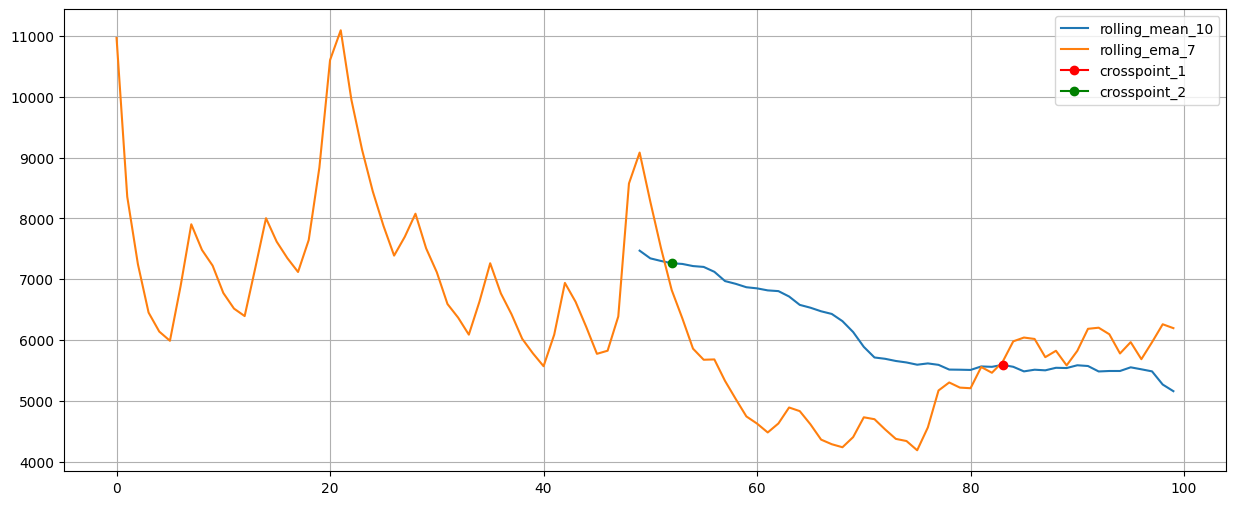

In [16]:
## визуализируем
plt.figure(figsize=(15,6))
plt.plot(df_1.index, df_1.rolling_mean_50) ## среднее с окном в 50 точек
plt.plot(df_1.index, df_1.rolling_ema_10) ## экспоненциальное среднее с окном в 10 точек
plt.plot(83, 5589, '-ro') ## точка пересечения 1
plt.plot(52, 7261, '-go') ## точка пересечения 1
plt.legend(['rolling_mean_10', 'rolling_ema_7', 'crosspoint_1', 'crosspoint_2'])
plt.grid()

plt.show()

## 3.Лаги

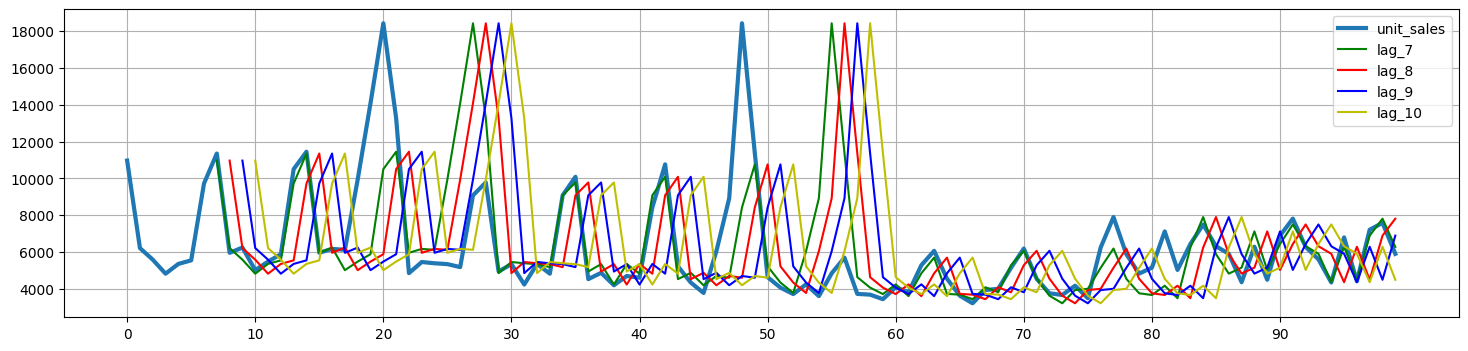

In [17]:
lags = range(7,11)
for i in lags:
    df_1[f'lag_{i}'] = df_1.unit_sales.shift(i)

# Визуализация
f, ax = plt.subplots(1, 1, figsize=(18, 4))
ax.plot(df_1.index, df_1.unit_sales, lw=3) ## исходные данные
ax.plot(df_1.index, df_1['lag_' + str(lags[0])],  c='g') 
ax.plot(df_1.index, df_1['lag_' + str(lags[1])],  c='r') 
ax.plot(df_1.index, df_1['lag_' + str(lags[2])],  c='b') 
ax.plot(df_1.index, df_1['lag_' + str(lags[3])],  c='y') 
ax.legend(['unit_sales', f'lag_{lags[0]}', f'lag_{lags[1]}', f'lag_{lags[2]}', f'lag_{lags[3]}'])
ax.grid()
plt.xticks(df_1.index.values[::10]);

## 4. Обучение моделей регрессии для временных рядов. ARIMA/SARIMA

### 4.1 Обработка данных

In [21]:
#Выберите продукт с номером 103501 (item_nbr)
#приведите данные к виду временного ряда с группировкой по дате и агрегацией .sum()['unit_sales']    
chunksize = 10 ** 6  
df = pd.DataFrame(columns=['date', 'unit_sales'])
for chunk in pd.read_csv('/content/drive/MyDrive/SF/data/time series/train.zip', chunksize=chunksize, low_memory=False):
  chunk = chunk[chunk.item_nbr == 103501].groupby("date").sum()['unit_sales'].reset_index()
  df = pd.concat([df,chunk])
df = df.groupby("date").sum().reset_index() 
df['date'] = pd.to_datetime(df['date'])
df.to_csv("/content/drive/MyDrive/SF/data/time series/arima.csv", index=False)

<ipython-input-21-57168da5ab06>:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  chunk = chunk[chunk.item_nbr == 103501].groupby("date").sum()['unit_sales'].reset_index()


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1625 entries, 0 to 1624
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        1625 non-null   datetime64[ns]
 1   unit_sales  1625 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 25.5 KB


In [23]:
unit_sales_by_date = df.groupby('date').sum()['unit_sales']
unit_sales_by_date.head()

date
2013-01-02    185.0
2013-01-03    153.0
2013-01-04    155.0
2013-01-05    160.0
2013-01-06    173.0
Name: unit_sales, dtype: float64

In [24]:
#тест Адфуллера. Стационарен ли ряд?
test = adfuller(unit_sales_by_date)
print ('adf: ', test[0] )
print ('p-value: ', test[1])
print ('Critical values: ', test[4])
if test[0]> test[4]['5%']: # проверка, больше ли критического полученное значение для нашего ряда 
    print ('ряд не стационарен')
else:
    print ('ряд стационарен')

adf:  -4.154403058014621
p-value:  0.0007863083913836263
Critical values:  {'1%': -3.4344462031760283, '5%': -2.8633492329988335, '10%': -2.5677331999518147}
ряд стационарен


Ряд - стационарный. Если бы ряд был нестационарным, нам необходимо было бы продифференцировать ряд до тех пор, пока бы мы не получили стационарный ряд. Количество дифференцирований будет опреледелять пораметр d в модели ARIMA. В нашем случае d=0, так как к дифференцированию мы не прибегали.

### 4.2 Модель скользящего среднего

Реализуем модель скользящего среднего. За окно попробуем взять 6 дней. После чего сравним результат с последними 6 днями, которые не использовали в рассчете скользящего среднего. Посчитаем метрики MSE, MAE, MAPE.

In [25]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

mean_squared_error 287.087962962963
mean_absolute_error 13.416666666666666
mean_absolute_percentage_error 0.17213844967435177


Text(0.5, 1.0, 'Скользящее среднее')

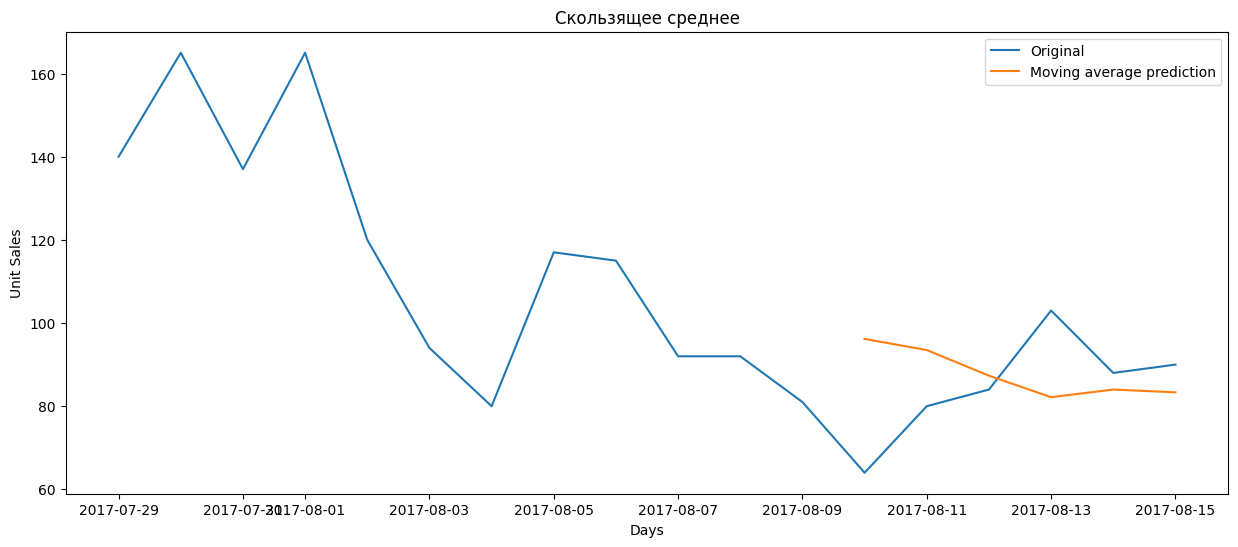

In [28]:
def moving_average_forecast(series, window_size):
    forecast = []
    for time in range(len(series) - window_size):
        forecast.append(series[time:time + window_size].mean())
    return np.array(forecast)
moving_average_days = 6

shown_train_size = moving_average_days * 3
moving_avg = moving_average_forecast(unit_sales_by_date,moving_average_days )
moving_avg = pd.Series(moving_avg, index = unit_sales_by_date[moving_average_days:].index)

print("mean_squared_error",mean_squared_error(unit_sales_by_date.values[-moving_average_days:], moving_avg[-moving_average_days:]))
print("mean_absolute_error",mean_absolute_error(unit_sales_by_date.values[-moving_average_days:], moving_avg[-moving_average_days:]))
print("mean_absolute_percentage_error",mean_absolute_percentage_error(unit_sales_by_date.values[-moving_average_days:], moving_avg[-moving_average_days:]))

# Лаги с 1 по 6
df = pd.DataFrame()
df["Original Values"]  = unit_sales_by_date
df["shift1"] = df["Original Values"].shift()
df["shift2"] = df["shift1"].shift()
df["shift3"] = df["shift2"].shift()
df["shift4"] = df["shift3"].shift()
df["shift5"] = df["shift4"].shift()
df["shift6"] = df["shift5"].shift()
df.dropna(inplace=True)

plt.figure(figsize=(15,6))

plt.plot(unit_sales_by_date[- shown_train_size:], label="Original")
plt.plot(moving_avg[-moving_average_days:], label="Moving average prediction")
plt.ylabel("Unit Sales")
plt.xlabel("Days")
plt.legend(loc="upper right")
plt.title("Скользящее среднее")

**Предсказание не совсем похоже на тренд оригинала**





### 4.3 Модель линейной регрессии

[ 0.40402026  0.02908831 -0.02177649 -0.10529843  0.08201362  0.51098893
  0.04639527 -0.2871312  -0.08664069  0.01211946  0.10741664]
31.227245515451614
mean_squared_error 7.867325681454291
mean_absolute_error 2.8000532214224023
mean_absolute_percentage_error 0.031486002216425064


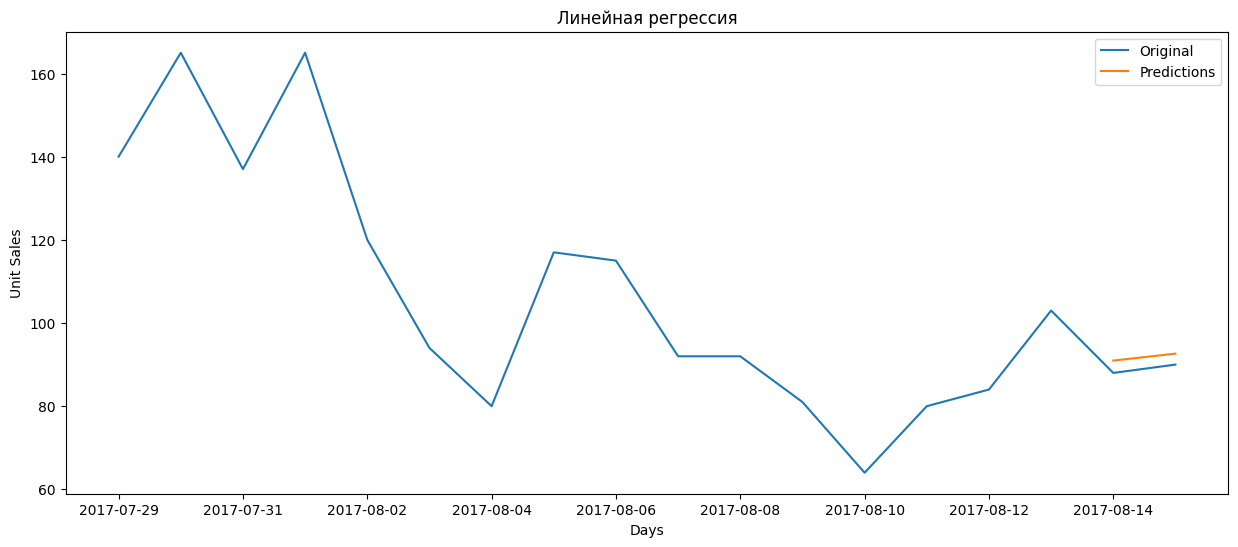

In [29]:
predict_size = 2
df["shift7"] = df["shift6"].shift()
df["shift8"] = df["shift7"].shift()
df["shift9"] = df["shift8"].shift()
df["shift10"] = df["shift9"].shift()
df["shift11"] = df["shift10"].shift()
df["shift12"] = df["shift11"].shift()
df.drop(['shift1'], axis=1, inplace=True) # шаг с лагом 1 меньше размера теста - удаляем
df.dropna(inplace=True)

x_train, y_train = df[:-predict_size].drop(["Original Values"], axis =1), df[:-predict_size]["Original Values"]
x_test, y_test  = df[-predict_size:].drop(["Original Values"], axis =1), df[-predict_size:]["Original Values"]


from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(x_train, y_train)
print(reg.coef_)
print(reg.intercept_)


ar_predictions = pd.Series(reg.predict(x_test), index=x_test.index)

plt.figure(figsize=(15,6))
plt.plot(pd.concat([y_train, y_test], axis = 0)[-shown_train_size:], label = "Original" )
plt.plot(ar_predictions ,label = "Predictions")
plt.ylabel("Unit Sales")
plt.xlabel("Days")
plt.legend(loc="upper right")
plt.xticks(unit_sales_by_date[- shown_train_size:].index[::2])
plt.title("Линейная регрессия")

print("mean_squared_error",mean_squared_error(y_test, ar_predictions))
print("mean_absolute_error",mean_absolute_error(y_test, ar_predictions))
print("mean_absolute_percentage_error",mean_absolute_percentage_error(y_test, ar_predictions))

Тут модель неплохо предсказала тренд на двух днях.

### 4.4 Модель ARIMA/SARIMA

Итак, чтобы построить ARIMA модель нам нужно знать ее порядок, состоящий из 3-х параметров:
    
    p — порядок компоненты AR
    d — порядок интегрированного ряда
    q — порядок компонетны MA
    
d мы уже знаем - это 0

осталось определить p и q. Для их определения нам надо изучить авторкорреляционную(ACF) и частично автокорреляционную(PACF) функции для ряда первых разностей.

ACF поможет нам определить q, т. к. по ее коррелограмме можно определить количество автокорреляционных коэффициентов сильно отличных от 0 в модели MA
PACF поможет нам определить p, т. к. по ее коррелограмме можно определить максимальный номер коэффициента сильно отличный от 0 в модели AR.

Чтобы построить соответствующие коррелограммы, в пакете statsmodels имеются следующие функции: plot_acf() и plot_pacf(). Они выводят графики ACF и PACF, у которых по оси X откладываются номера лагов, а по оси Y значения соответствующих функций. Нужно отметить, что количество лагов в функциях и определяет число значимых коэффициентов.

/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


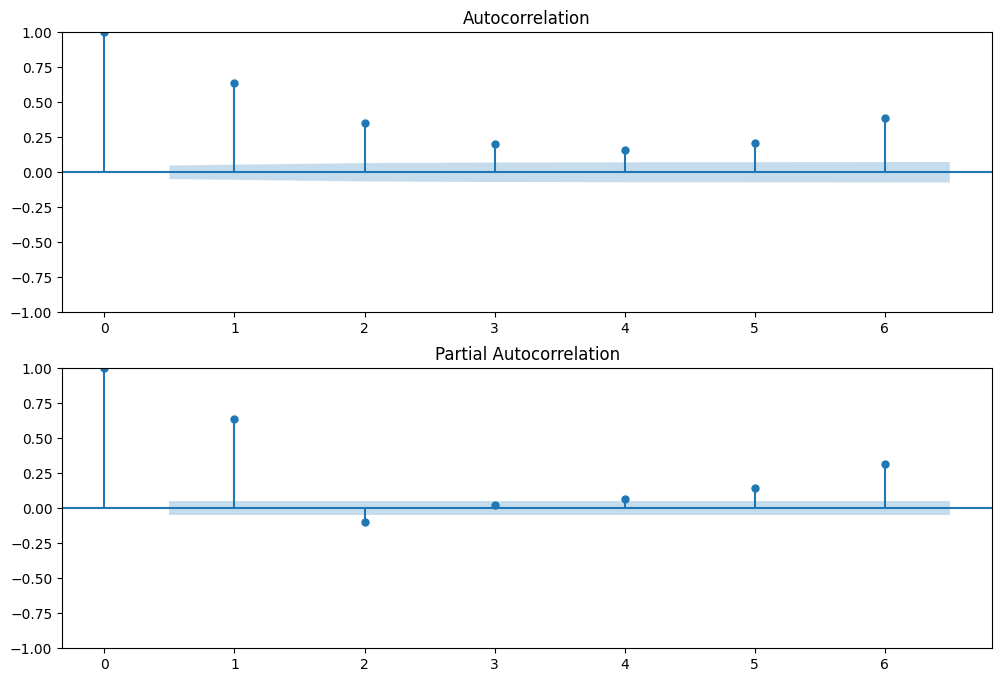

In [30]:
import statsmodels.api as sm
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(unit_sales_by_date.values.squeeze(), lags=6, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(unit_sales_by_date, lags=6, ax=ax2)

После изучения коррелограммы PACF можно сделать вывод, что p = 6, т.к. на ней все лаги сильно отличны от нуля.
По коррелограмме ACF можно предположить, что q = 6, т.к. на лаг 6 значении функций резко возрастает. Итак, когда известны все параметры можно построить модель.

In [31]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(y_train.values.reshape(-1), order=(6,0,6))

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


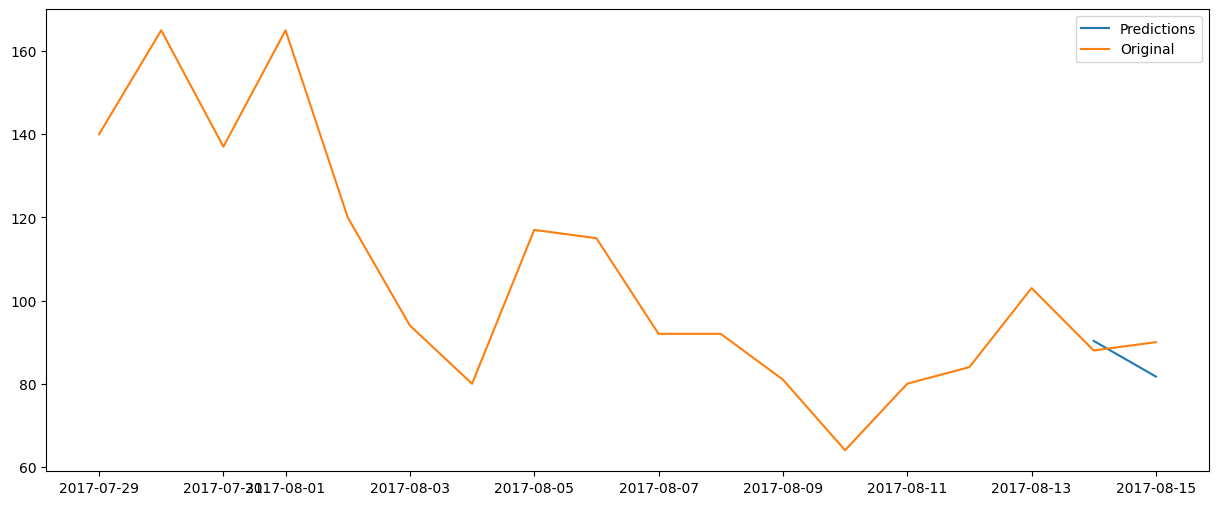

In [36]:
train_size = len(y_train)
arima_predictions = model.fit().predict(start=train_size,end=train_size+predict_size -1,  dynamic=False)

plt.figure(figsize=(15,6))
plt.plot(pd.Series(arima_predictions, index=y_test.index) ,label = "Predictions");
plt.plot(unit_sales_by_date.index[-shown_train_size:], np.hstack([y_train, y_test.values])[-shown_train_size:], label = "Original" );
plt.legend(loc="upper right");

In [33]:
print("mean_squared_error",mean_squared_error(y_test, arima_predictions))
print("mean_absolute_error",mean_absolute_error(y_test, arima_predictions))
print("mean_absolute_percentage_error",mean_absolute_percentage_error(y_test, arima_predictions))

mean_squared_error 36.88764388783928
mean_absolute_error 5.287397705561567
mean_absolute_percentage_error 0.0590391295848235


ARIMA показала хуже результат, чем линейная регрессия.

## 5. FPProphet

In [59]:
!pip install plotly

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [49]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
import pandas as pd
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 70)
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode()

from prophet import Prophet

%time df_holidays_events = pd.read_csv('/content/drive/MyDrive/SF/data/time series/holidays_events.zip')

print('Data and libraries are loaded.')

CPU times: user 50.8 ms, sys: 524 µs, total: 51.4 ms
Wall time: 641 ms
CPU times: user 10.1 ms, sys: 124 µs, total: 10.2 ms
Wall time: 255 ms
Data and libraries are loaded.


In [53]:
chunksize = 10 ** 6  
df = pd.DataFrame(columns=['date', 'unit_sales'])
for chunk in pd.read_csv('/content/drive/MyDrive/SF/data/time series/train.zip', chunksize=chunksize, low_memory=False):
    chunk = chunk.groupby("date")['unit_sales'].sum().reset_index()
    df = pd.concat([df,chunk])
df = df.groupby("date").sum().reset_index() 
df['date'] = pd.to_datetime(df['date'])
df.rename(columns = {'unit_sales':'sum_unit_sales'}, inplace = True )
df.to_csv("/content/drive/MyDrive/SF/data/time series/sum_unit_sales.csv", index=False)

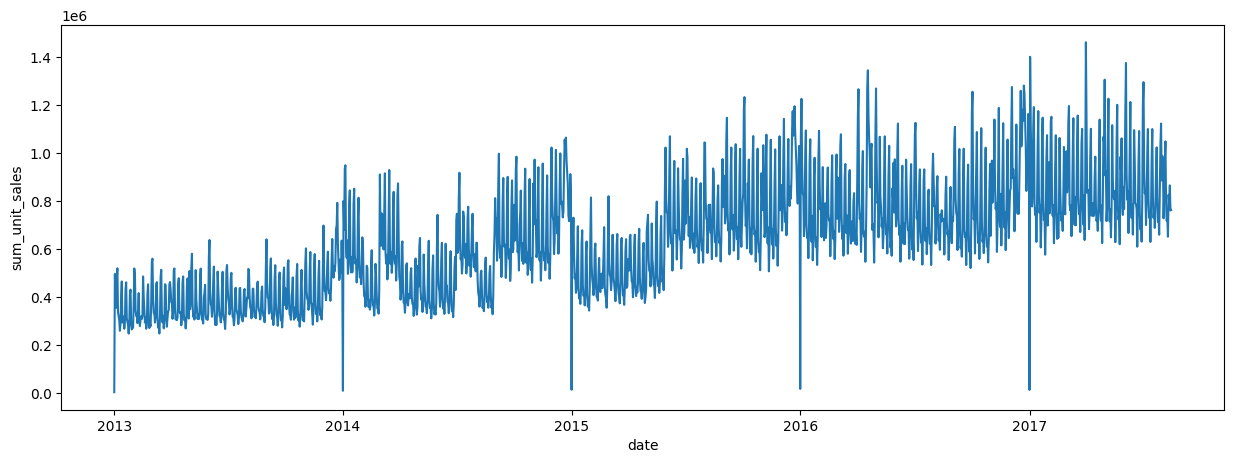

In [67]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(15, 5))
sns.lineplot(x=df.date, y=df.sum_unit_sales, ax=ax)
plt.show()

Хорошо заметно влияние сезонности и праздников на общий объем транзакций.

Теперь давайте попробуем библиотеку пророк и посмотрим, насколько хорошо она предсказывает. Но перед этим мы должны подготовить данные. Согласно документации:

> Prophet следует API модели sklearn. Мы создаем экземпляр класса Prophet, а затем вызываем его методы соответствия и прогнозирования.
> Входными данными для Prophet всегда является фрейм данных с двумя столбцами: ** ds ** и ** y **. Столбец ds (отметка даты) должен содержать дату или дату и время (это нормально). Столбец ** y ** должен быть числовым и представлять измерение, которое мы хотим спрогнозировать.

In [68]:
df.rename(columns = {'date':'ds', 'sum_unit_sales':'y'}, inplace = True )

In [69]:
m = Prophet()
m.fit(df)
future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [70]:
forecast

ds          trend     yhat_lower    yhat_upper    trend_lower  \
0    2013-01-01  335692.910639  232195.856250  5.037198e+05  335692.910639   
1    2013-01-02  336058.638266  250663.308751  5.419347e+05  336058.638266   
2    2013-01-03  336424.365893  155220.715129  4.253196e+05  336424.365893   
3    2013-01-04  336790.093520  218369.151120  5.004148e+05  336790.093520   
4    2013-01-05  337155.821148  400307.813643  6.688648e+05  337155.821148   
...         ...            ...            ...           ...            ...   
2044 2018-08-11  987668.388663  901544.303057  1.184820e+06  945027.966825   
2045 2018-08-12  987926.942304  964889.232688  1.253790e+06  945125.117928   
2046 2018-08-13  988185.495945  746519.905105  1.048228e+06  945222.269030   
2047 2018-08-14  988444.049585  703229.800030  9.969697e+05  945319.420132   
2048 2018-08-15  988702.603226  730928.845097  1.006368e+06  945416.571235   

       trend_upper  additive_terms  additive_terms_lower  \
0     3.356929e+05    43386.870519          43386.870519   
1     3.360586e+05    55408.357648          55408.357648   
2     3.364244e+05   -44218.548332         -44218.548332   
3     3.367901e+05    18841.861876          18841.861876   
4     3.371558e+05   198413.798344         198413.798344   
...            ...             ...                   ...   
2044  1.032590e+06    62781.748795          62781.748795   
2045  1.033032e+06   116672.121427         116672.121427   
2046  1.033471e+06   -92721.579202         -92721.579202   
2047  1.033874e+06  -138937.822600        -138937.822600   
2048  1.034270e+06  -113536.220333        -113536.220333   

      additive_terms_upper         weekly   weekly_lower   weekly_upper  \
0             43386.870519  -68157.100909  -68157.100909  -68157.100909   
1             55408.357648  -44205.240199  -44205.240199  -44205.240199   
2            -44218.548332 -131882.359163 -131882.359163 -131882.359163   
3             18841.861876  -57031.141020  -57031.141020  -57031.141020   
4            198413.798344  134004.334674  134004.334674  134004.334674   
...                    ...            ...            ...            ...   
2044          62781.748795  134004.334674  134004.334674  134004.334674   
2045         116672.121427  188406.503765  188406.503765  188406.503765   
2046         -92721.579202  -21134.997148  -21134.997148  -21134.997148   
2047        -138937.822600  -68157.100909  -68157.100909  -68157.100909   
2048        -113536.220333  -44205.240199  -44205.240199  -44205.240199   

             yearly   yearly_lower   yearly_upper  multiplicative_terms  \
0     111543.971428  111543.971428  111543.971428                   0.0   
1      99613.597846   99613.597846   99613.597846                   0.0   
2      87663.810831   87663.810831   87663.810831                   0.0   
3      75873.002896   75873.002896   75873.002896                   0.0   
4      64409.463669   64409.463669   64409.463669                   0.0   
...             ...            ...            ...                   ...   
2044  -71222.585879  -71222.585879  -71222.585879                   0.0   
2045  -71734.382338  -71734.382338  -71734.382338                   0.0   
2046  -71586.582054  -71586.582054  -71586.582054                   0.0   
2047  -70780.721690  -70780.721690  -70780.721690                   0.0   
2048  -69330.980134  -69330.980134  -69330.980134                   0.0   

      multiplicative_terms_lower  multiplicative_terms_upper          yhat  
0                            0.0                         0.0  3.790798e+05  
1                            0.0                         0.0  3.914670e+05  
2                            0.0                         0.0  2.922058e+05  
3                            0.0                         0.0  3.556320e+05  
4                            0.0                         0.0  5.355696e+05  
...                          ...                         ...           ...  
2044          

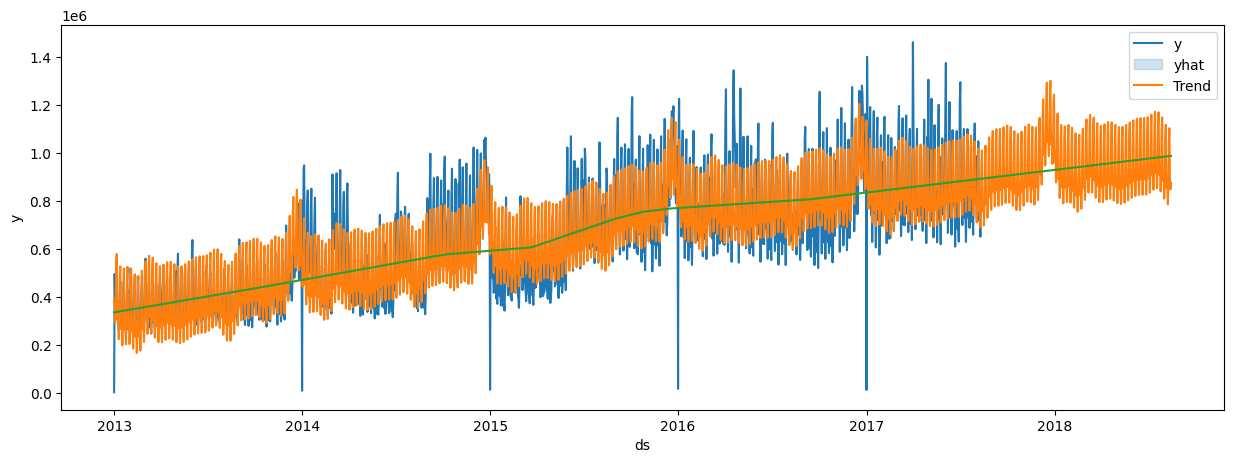

In [79]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.lineplot(x=df['ds'], y=df['y'])
sns.lineplot(x=forecast['ds'], y=forecast['yhat'])
sns.lineplot(x=forecast['ds'], y=forecast['trend'])
plt.legend(labels=['y', 'yhat', 'Trend'])
plt.show()

In [82]:
# Вычислим среднеквадратичную ошибку.
print('RMSE: %f' % np.sqrt(np.mean((forecast.loc[:1682, 'yhat']-df['y'])**2)) )

RMSE: 107965.022987


Поэкспериментируйте с коэффициентом changepoint_prior_scale (переберите 3-5 значений, больше/меньше 0,5) и посмотрите, как изменится тренд. В какую сторону необходимо двигать коэффициент? Тренд переобучен или недообучен?

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


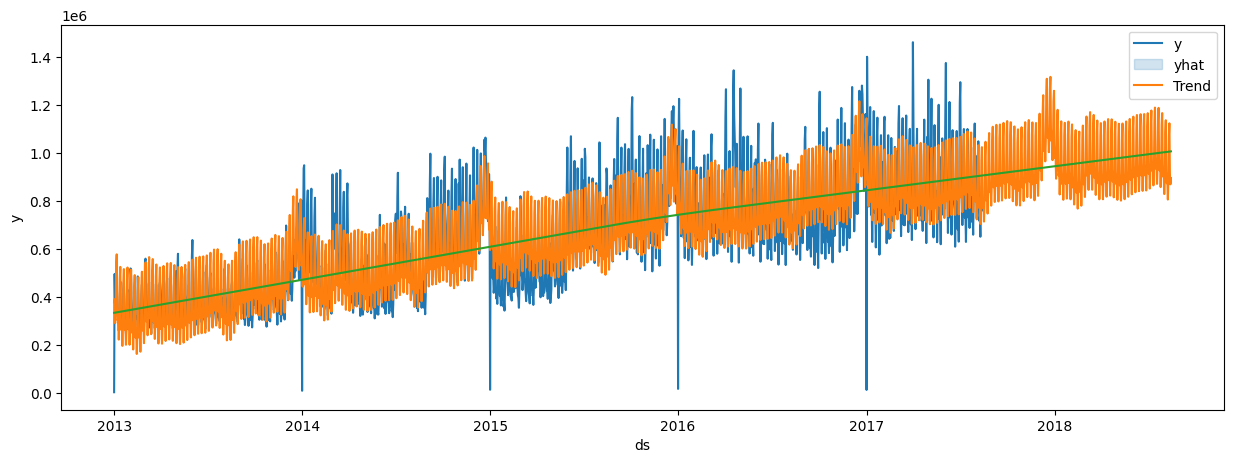

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


RMSE witn changepoint_prior_scale=0.01: 110873.205719


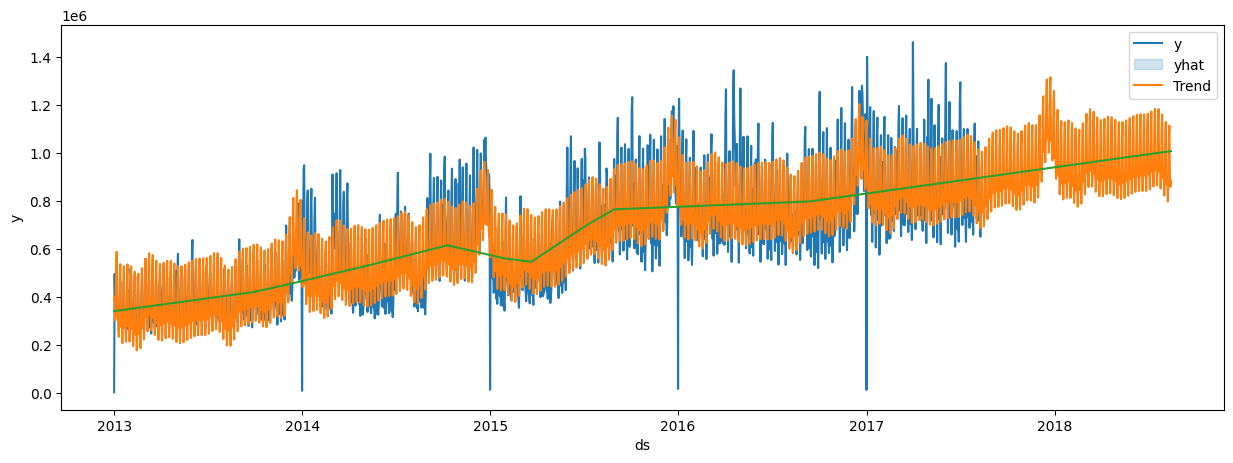

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


RMSE witn changepoint_prior_scale=0.1: 104091.945553


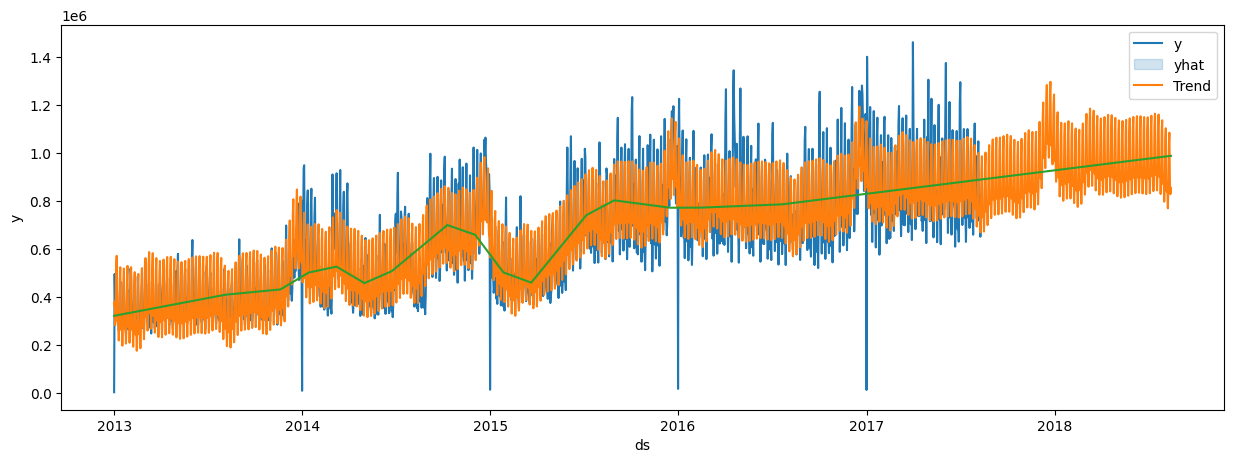

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


RMSE witn changepoint_prior_scale=0.5: 98617.981751


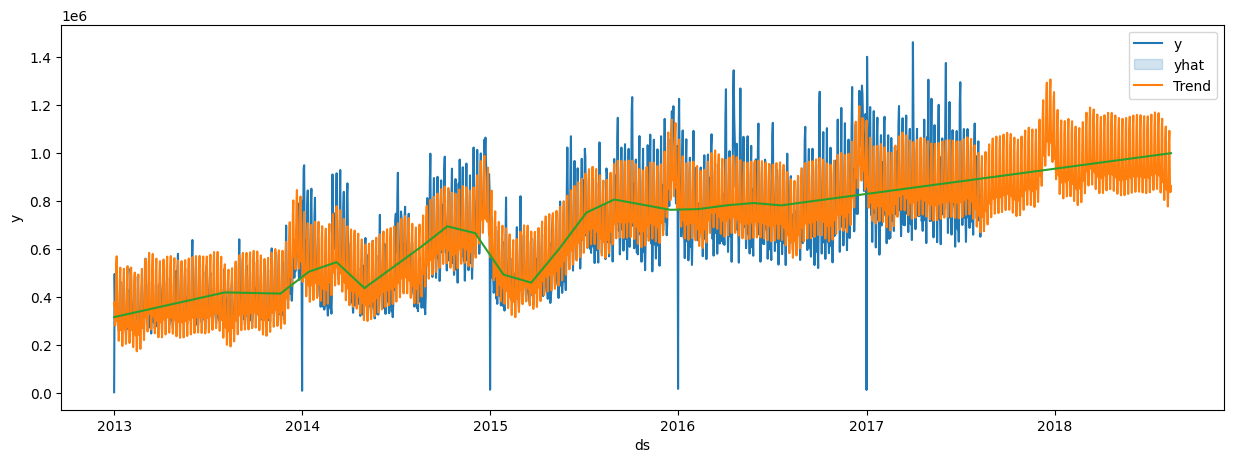

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


RMSE witn changepoint_prior_scale=0.75: 97998.192789


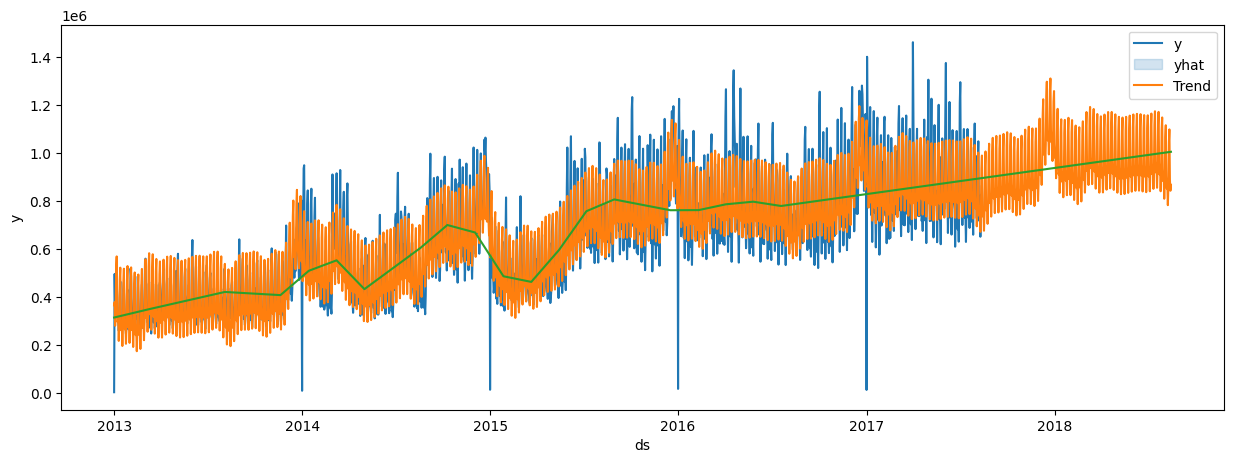

RMSE witn changepoint_prior_scale=1.0: 97784.060640


In [88]:
for i in [0.01, 0.1, 0.5, 0.75, 1.0]:
  m = Prophet(changepoint_prior_scale=i)
  m.fit(df)
  future = m.make_future_dataframe(periods=365)
  forecast = m.predict(future)
  fig, ax = plt.subplots(figsize=(15, 5))
  sns.lineplot(x=df['ds'], y=df['y'])
  sns.lineplot(x=forecast['ds'], y=forecast['yhat'])
  sns.lineplot(x=forecast['ds'], y=forecast['trend'])
  plt.legend(labels=['y', 'yhat', 'Trend'])
  plt.show()
  print(f'RMSE witn changepoint_prior_scale={i}: %f' % np.sqrt(np.mean((forecast.loc[:1682, 'yhat']-df['y'])**2)) )

При увеличении "changepoint_prior_scale" снижается ошибка RMSE, но при этом линия тренда заметно переобучается

**Добавление сезонности**

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


RMSE: 97749.522721


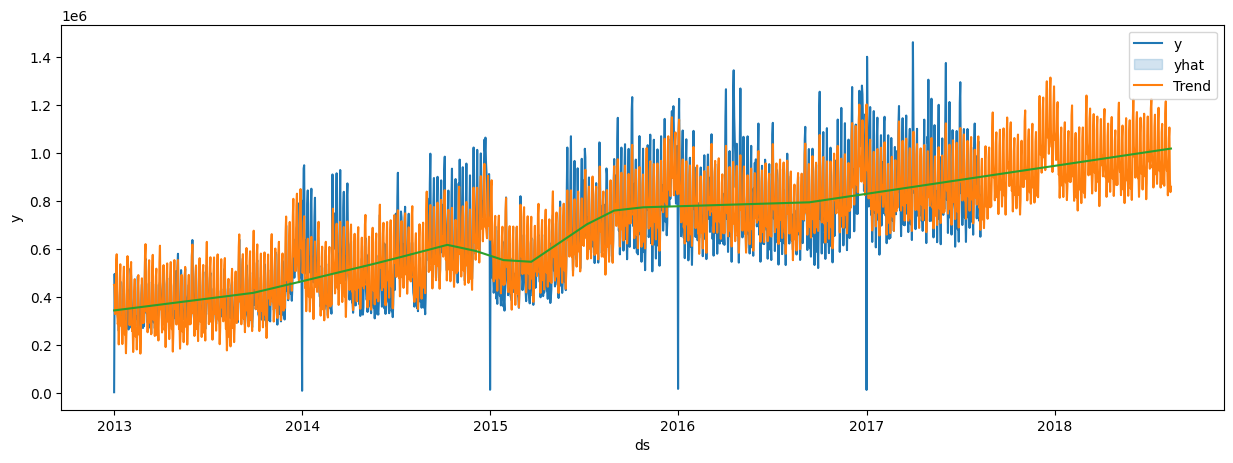

In [89]:
m = Prophet(changepoint_prior_scale=0.1)
m.add_seasonality(name='monthly', period=30.5, fourier_order=5)
m.fit(df)
future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)
# Вычислим среднеквадратичную ошибку.
print('RMSE: %f' % np.sqrt(np.mean((forecast.loc[:1682, 'yhat']-df['y'])**2)) )
fig, ax = plt.subplots(figsize=(15, 5))
sns.lineplot(x=df['ds'], y=df['y'])
sns.lineplot(x=forecast['ds'], y=forecast['yhat'])
sns.lineplot(x=forecast['ds'], y=forecast['trend'])
plt.legend(labels=['y', 'yhat', 'Trend'])
plt.show()

Модель улучшилась, ошибка уменьшилась.

**Добавление данных о праздниках**

In [90]:
holidays = df_holidays_events[df_holidays_events['transferred'] == False][['description', 'date']]
holidays.columns = ['holiday', 'ds']
holidays

holiday          ds
0               Fundacion de Manta  2012-03-02
1    Provincializacion de Cotopaxi  2012-04-01
2              Fundacion de Cuenca  2012-04-12
3        Cantonizacion de Libertad  2012-04-14
4        Cantonizacion de Riobamba  2012-04-21
..                             ...         ...
345                      Navidad-3  2017-12-22
346                      Navidad-2  2017-12-23
347                      Navidad-1  2017-12-24
348                        Navidad  2017-12-25
349                      Navidad+1  2017-12-26

[338 rows x 2 columns]

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


RMSE: 79152.798825


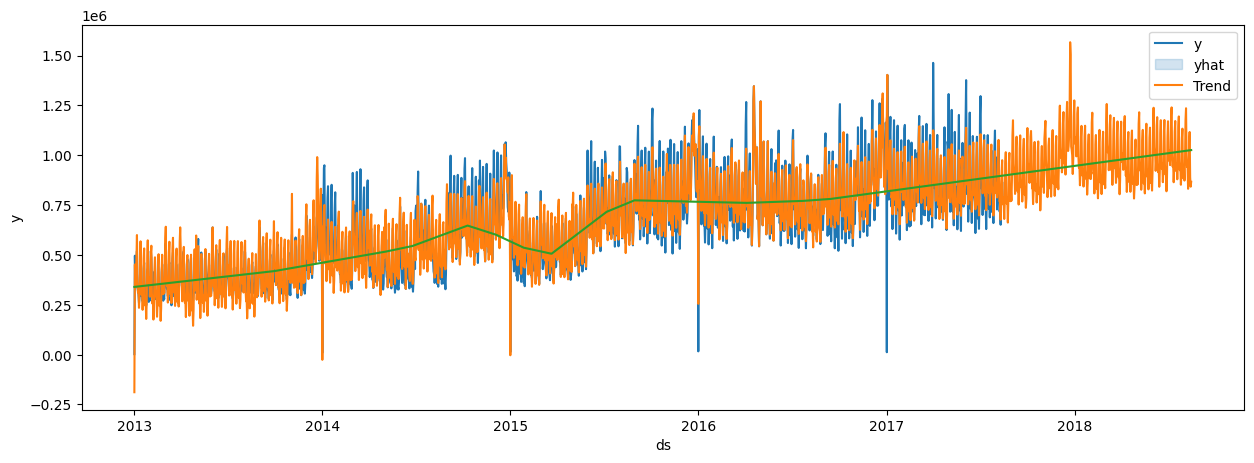

In [91]:
m = Prophet(changepoint_prior_scale=0.1, holidays=holidays)
m.add_seasonality(name='monthly', period=30.5, fourier_order=5)
m.fit(df)
future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)
# Вычислим среднеквадратичную ошибку.
print('RMSE: %f' % np.sqrt(np.mean((forecast.loc[:1682, 'yhat']-df['y'])**2)) )
fig, ax = plt.subplots(figsize=(15, 5))
sns.lineplot(x=df['ds'], y=df['y'])
sns.lineplot(x=forecast['ds'], y=forecast['yhat'])
sns.lineplot(x=forecast['ds'], y=forecast['trend'])
plt.legend(labels=['y', 'yhat', 'Trend'])
plt.show()

При добавлении данных о праздниках ошибка значительно уменьшилась.

## 6.XGBoost и CaTBoost для временных рядов 

Правильным образом разбейте данные на train и test.

In [95]:
df = df.set_index(pd.DatetimeIndex(df['ds'])) 
df.drop(['ds'], axis=1, inplace=True)
split_date = '01-Jan-2017'
sales_train = df.loc[df.index <= split_date].copy()
sales_test = df.loc[df.index > split_date].copy()

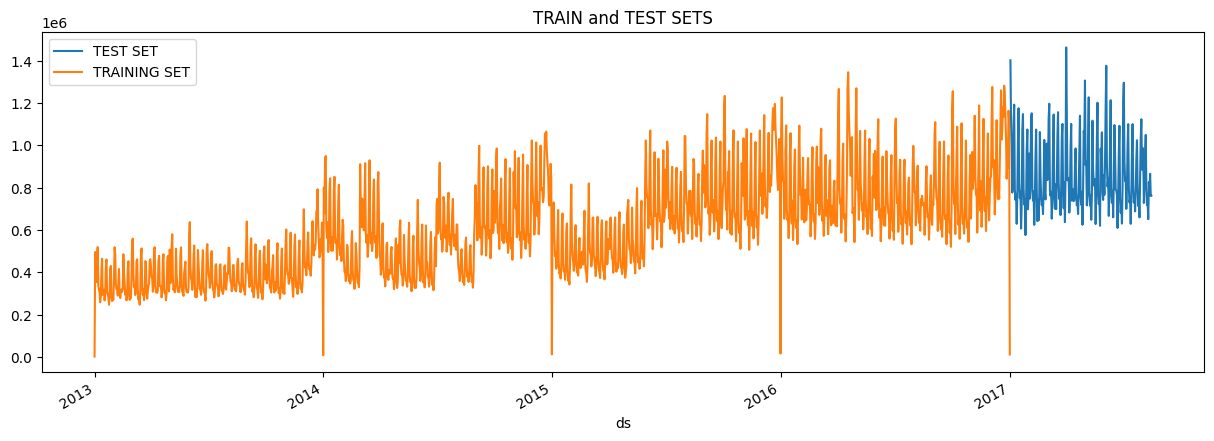

In [96]:
_ = sales_test \
    .rename(columns={'y': 'TEST SET'}) \
    .join(sales_train.rename(columns={'y': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(15,5), title='TRAIN and TEST SETS', style='-')

Создайте временные признаки от datetime.

In [97]:
def create_features(df, label=None):
    """
    создаем признаки из datetime индекса
    """
    df['date'] = df.index
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

In [98]:
X_train, y_train = create_features(sales_train, label='y')
X_test, y_test = create_features(sales_test, label='y')

<ipython-input-97-f86eaee02582>:12: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.

<ipython-input-97-f86eaee02582>:12: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.



### Инициализируйте и обучите модели XGBoost.

In [99]:
import xgboost as xgb
from xgboost import plot_importance, plot_tree

reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=False) # Измените verbose на True, если хотите увидеть процесс обучения

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

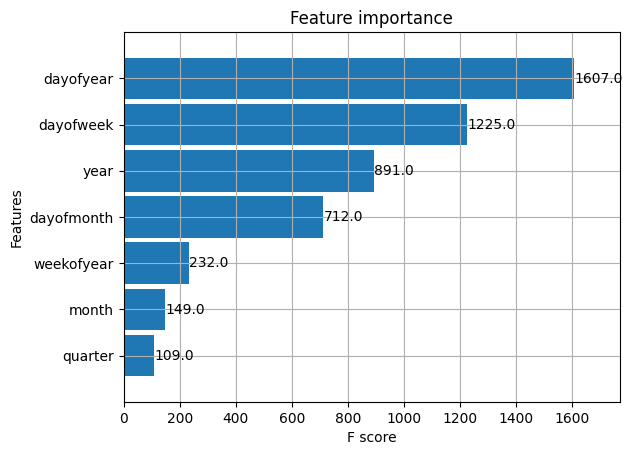

In [100]:
#Важность признаков
_ = plot_importance(reg, height=0.9)

Мы видим, что день года чаще всего использовался для разделения деревьев, а затем следуют неделя года и год. Квартал имеет невысокую важность в связи с тем, что он мог быть создан разным разбиением по дням и годам.

Сделайте прогноз и отобразите результат на графике.

In [101]:
sales_test['Prediction'] = reg.predict(X_test)
sales_all = pd.concat([sales_test, sales_train], sort=False)

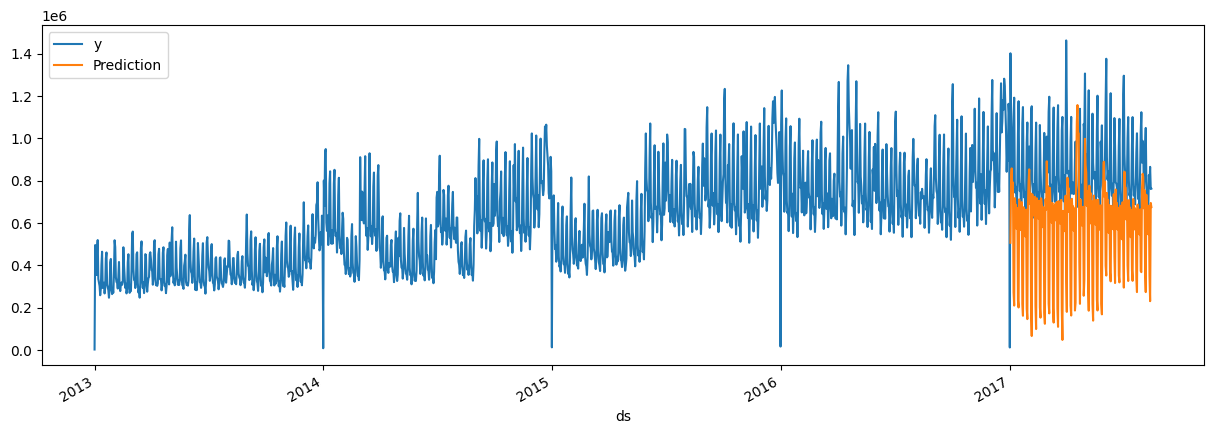

In [102]:
_ = sales_all[['y','Prediction']].plot(figsize=(15, 5))

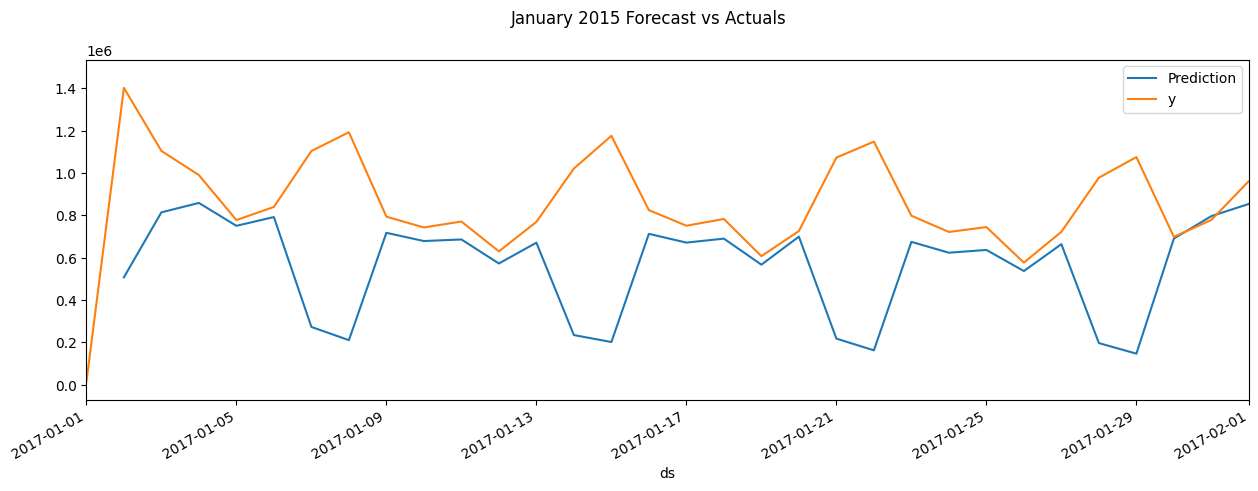

In [103]:
#Посмотрим на первый месяц прогнозов
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = sales_all[['Prediction','y']].plot(ax=ax,
                                              style=['-','-'])
ax.set_xbound(lower='01-01-2017', upper='02-01-2017')
#ax.set_ylim(0, 60000)
plot = plt.suptitle('January 2015 Forecast vs Actuals')

### Ошибки на Test Set модели XGBoost
 RMSE  is 208137362297  
 MAE  is 301348  
 MAPE  is 30.3%

In [104]:
mean_squared_error(y_true=sales_test['y'],
                   y_pred=sales_test['Prediction'])

208137362297.9551

In [105]:
mean_absolute_error(y_true=sales_test['y'],
                   y_pred=sales_test['Prediction'])

301348.86494137166

In [106]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """считаем MAPE по y_true и y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [107]:
mean_absolute_percentage_error(y_true=sales_test['y'],
                   y_pred=sales_test['Prediction'])

30.300732300036458

### Инициализируйте и обучите модели CatBoost.

In [110]:
#!pip install catboost

In [112]:
from catboost import CatBoostRegressor

cbr = CatBoostRegressor(n_estimators=1000)
cbr.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=False)

In [113]:
sales_test['Prediction_catboost'] = cbr.predict(X_test)
sales_all = pd.concat([sales_test, sales_train], sort=False)

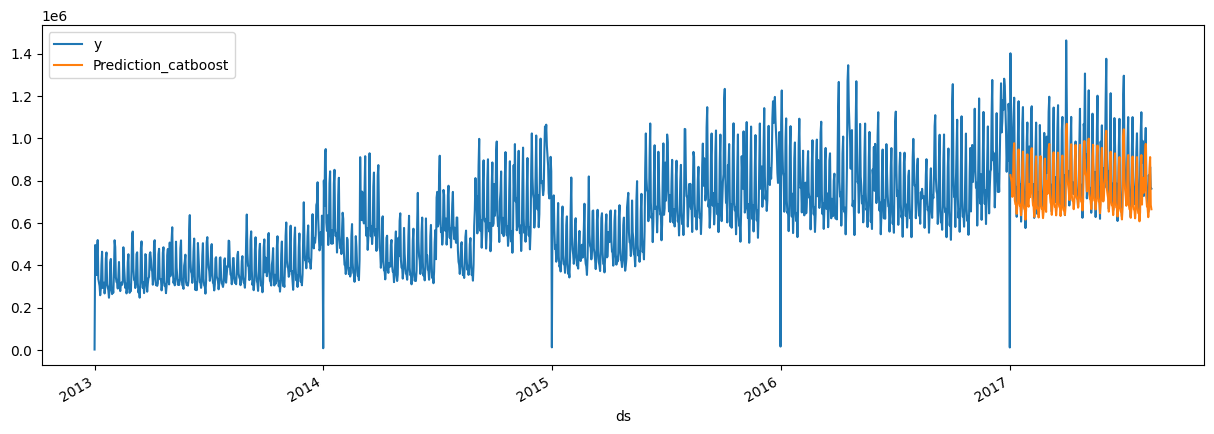

In [114]:
_ = sales_all[['y','Prediction_catboost']].plot(figsize=(15, 5))

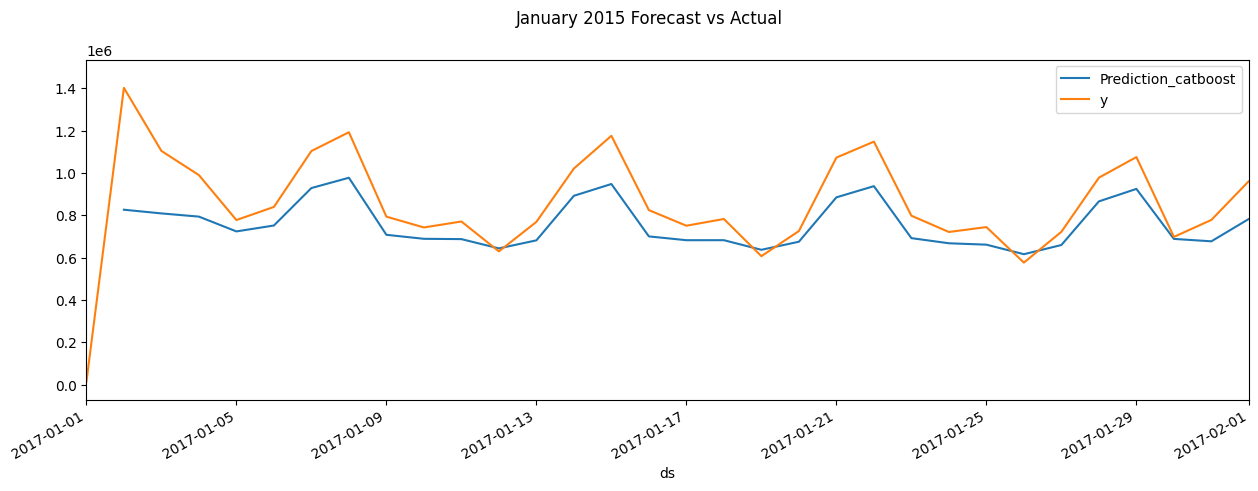

In [115]:
#Посмотрим на первый месяц прогнозов
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = sales_all[['Prediction_catboost','y']].plot(ax=ax,
                                              style=['-','-'])
ax.set_xbound(lower='01-01-2017', upper='02-01-2017')
#ax.set_ylim(0, 60000)
plot = plt.suptitle('January 2015 Forecast vs Actual')

### Ошибки на Test Set модели CatBoost и XGBoost


> XGBoost:

 RMSE  is 208137362297
 
 MAE  is 301348  
 
 MAPE  is 30.3%

> CatBoost:

 RMSE  is 1701816049

 MAE  is 103095  
 
 MAPE  is 11.1%



In [116]:
mean_squared_error(y_true=sales_test['y'],
                   y_pred=sales_test['Prediction_catboost'])

17018160492.4127

In [117]:
mean_absolute_error(y_true=sales_test['y'],
                   y_pred=sales_test['Prediction_catboost'])

103095.1806365714

In [118]:
mean_absolute_percentage_error(y_true=sales_test['y'],
                   y_pred=sales_test['Prediction_catboost'])

11.11520249832649

**Сравнение метрик моделей XGBoost и CatBoost показывает, что CatBoost показывает лучшие результаты.**

### Добавление данные о праздничных днях

In [120]:
import holidays 

holidays = holidays.US() 
sales_test['is_holidays'] = sales_test.apply(lambda row: 1 if row.date in holidays else 0, axis=1)
sales_train['is_holidays'] = sales_train.apply(lambda row: 1 if row.date in holidays else 0, axis=1)

In [121]:
X_train = sales_train.drop(['y', 'date'], axis=1)
y_train = sales_train['y']
X_test, y_test = sales_test.drop(['y', 'Prediction', 'Prediction_catboost', 'date'], axis=1), sales_test['y']

In [122]:
cbr_hol = CatBoostRegressor(n_estimators=1000)
cbr_hol.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=False)

### Ошибки на Test Set модели CatBoost c учетом праздников


> CatBoost:

 RMSE  is 1701816049

 MAE  is 103095  
 
 MAPE  is 11.1%

> CatBoost с учетом выходных:

 RMSE  is 17705274060

 MAE  is 106738  
 
 MAPE  is 11.6%



In [123]:
sales_test['Prediction_catboost'] = cbr_hol.predict(X_test)
sales_all = pd.concat([sales_test, sales_train], sort=False)

In [124]:
mean_squared_error(y_true=sales_test['y'],
                   y_pred=sales_test['Prediction_catboost'])

17705274060.765297

In [125]:
mean_absolute_error(y_true=sales_test['y'],
                   y_pred=sales_test['Prediction_catboost'])

106738.19742564287

In [126]:
mean_absolute_percentage_error(y_true=sales_test['y'],
                   y_pred=sales_test['Prediction_catboost'])

11.616092749017012

Добавление в признаки информации о праздниках ухудшило метрики Сatboost.

#### Добавьте лаги. Обратите внимание на размер тестовой выборки: она будет влиять на допустимое значение для лагов (лаг не менее test set shape)

In [127]:
y_train_df = pd.DataFrame(columns=['y'])
y_test_df = pd.DataFrame(columns=['y'])

In [128]:
y_train_df['y'] = y_train.values
y_test_df['y'] = y_test.values

In [129]:
sales_all = pd.concat([sales_train, sales_test])

Добавляем 6 лагов, предполагая недельную цикличность

In [130]:
for i in range(6):
    sales_all[f'lag_{i}'] = sales_all.y.shift(i+len(X_test))

In [131]:
X = sales_all.drop(['y', 'date', 'Prediction', 'Prediction_catboost'], axis=1)

In [132]:
split_date = '01-Jan-2017'
X_train = X.loc[X.index <= split_date].copy()
X_test = X.loc[X.index > split_date].copy()
y_train = sales_all.y.loc[X.index <= split_date].copy()
y_test = sales_all.y.loc[X.index > split_date].copy()

In [133]:
cbr_lags = CatBoostRegressor(n_estimators=500)
cbr_lags.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=False)

In [135]:
sales_test['Prediction_catboost'] = cbr_lags.predict(X_test)
sales_all = pd.concat([sales_test, sales_train], sort=False)

### Ошибки на Test Set модели CatBoost лагов


> CatBoost (best metrics before add LAG`s):

 RMSE  is 1701816049

 MAE  is 103095  
 
 MAPE  is 11.1%

> CatBoost с учетом лагов:

 RMSE  is 16582937954

 MAE  is 100430 
 
 MAPE  is 10.8%



In [136]:
mean_squared_error(y_true=sales_test['y'],
                   y_pred=sales_test['Prediction_catboost'])

16582937954.134699

In [137]:
mean_absolute_error(y_true=sales_test['y'],
                   y_pred=sales_test['Prediction_catboost'])

100430.1114887846

In [138]:
mean_absolute_percentage_error(y_true=sales_test['y'],
                   y_pred=sales_test['Prediction_catboost'])

10.883969235667262

Добавление шести лагов незначительно улучшило метрики модели  Catboost. Наилучшие метрики достигнуты для модели Catboost без добавления данных о праздничных днях и c добавлением лагов.